# Uczenie maszynowe w analizie szeregów czasowych

## Dane

Do wykonania zadań będę posługiwać się szeregami czasowymi o różnych charakterystykach. Wszystkie dane są danymi miesięcznymi w przeciągu ostatnich 10 lat.
1. Szereg o wyraźnym trendzie 
- Production, Sales, Work Started and Orders: Production Volume: Economic Activity: Manufacturing for Poland
https://fred.stlouisfed.org/series/POLPROMANMISMEI
- Rzeczywisty produkt krajowy brutto dla Polski (z covidem)
https://fred.stlouisfed.org/series/NGDPRSAXDCPLQ
- Monetary Aggregates and Their Components: Broad Money and Components: M3 for Poland (bez covida)
https://fred.stlouisfed.org/series/MABMM301PLM189S
2. Szereg o wyraźnej sezonowości 
-  Harmonized Index of Consumer Prices: Passenger Transport by Air for Poland
https://fred.stlouisfed.org/series/CP0733PLM086NEST
3. Szereg bez określonych charakterystycznych wartości - 
- Zarejestrowane bezrobocie i wolne miejsca pracy: Gospodarka ogółem:Bezrobocie rejestrowane dla Polski
https://fred.stlouisfed.org/series/LMUNRLTTPLM647S (nw co to, głównie górki)
- Producer Price Index by Industry: New Car Dealers: Used Vehicle Sales
https://fred.stlouisfed.org/series/PCU441110441110102 (płasko i górki)
- Handel detaliczny ogółem:Wolumen dla Polski (szum biały)
https://fred.stlouisfed.org/series/POLSLRTTO01GPSAM

1. Szereg o wyraźnym trendzie 
- [ts1] Production, Sales, Work Started and Orders: Production Volume: Economic Activity: Manufacturing for Poland
https://fred.stlouisfed.org/series/POLPROMANMISMEI


# Biblioteki

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_absolute_error

# Dane

Dodać opis danych i kolejne szergi jeśli będzie trzeba.

In [82]:
# Wczytanie danych i konwersja na DataFrame
ts1 = pd.read_csv('ts1.csv')

# Wyświetlenie pięciu pierwszych wierszy
print(ts1.head())

         DATE  POLPROMANMISMEI
0  2014-03-01         93.81107
1  2014-04-01         95.06747
2  2014-05-01         93.39227
3  2014-06-01         94.64867
4  2014-07-01         95.90508


In [83]:
# Konwersja kolumny 'DATE' na typ daty
ts1['DATE'] = pd.to_datetime(ts1['DATE'], format='%Y-%m')

## Data processing


Ten fragment kodu konwertuje kolumnę 'Date' na typ daty, używając formatu %Y-%m, gdzie %Y reprezentuje rok, a %m miesiąc.

In [84]:
# Ustawienie kolumny 'DATE' jako indeks
ts1 = ts1.set_index('DATE')
# Ustawienie częstotliwości danych na miesięczną (start miesiąca)
ts1 = ts1.asfreq('MS')
# Wybór kolumny 'POLPROMANMISMEI'
ts1 = ts1['POLPROMANMISMEI']
# Sortowanie indeksu
ts1 = ts1.sort_index()
ts1.head(4)

DATE
2014-03-01    93.81107
2014-04-01    95.06747
2014-05-01    93.39227
2014-06-01    94.64867
Freq: MS, Name: POLPROMANMISMEI, dtype: float64

Ten krok ustawia kolumnę 'Date' jako indeks DataFrame, co pozwala na łatwiejsze operacje na szeregach czasowych.

DATE
2014-03-01    93.81107
2014-04-01    95.06747
2014-05-01    93.39227
2014-06-01    94.64867
Freq: MS, Name: POLPROMANMISMEI, dtype: float64

Ustawia częstotliwość indeksu na miesięczną, gdzie 'MS' oznacza początek miesiąca.



# Czym jest różnicowanie?

W kontekście analizy szeregów czasowych, "Data differentiated" odnosi się do procesu różnicowania danych (differencing), który jest techniką stosowaną w celu uczynienia szeregu czasowego stacjonarnym. Szereg czasowy jest stacjonarny, jeśli jego statystyki (takie jak średnia i wariancja) są stałe w czasie. Różnicowanie jest szczególnie przydatne, gdy dane mają trend lub sezonowość.

Różnicowanie polega na odejmowaniu wartości poprzedniego okresu od wartości bieżącej, co formalnie zapisuje się jako:

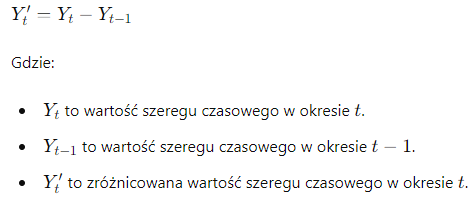

Jak to działa?

Różnicowanie pomaga usunąć trend i sezonowość z szeregu czasowego, co czyni go bardziej stacjonarnym. Jest to ważny krok w analizie szeregów czasowych.

Uzywamy do tego funkcji TimeSeriesDifferentiator (można poszukać opisów!)

In [85]:
diferenciator = TimeSeriesDifferentiator(order=1)


Tworzymy instancję klasy TimeSeriesDifferentiator, z parametrem order=1.
order=1 oznacza, że przeprowadzimy pierwsze różnicowanie (tj. różnicę pomiędzy każdą wartością a jej poprzednikiem).
TimeSeriesDifferentiator jest  częścią biblioteki specyficznej dla obróbki szeregów czasowych.

In [86]:
type(ts1)



pandas.core.series.Series

In [87]:
# Konwersja pandas.Series na numpy.ndarray
ts11 = ts1.values


In [88]:
type(ts11)

numpy.ndarray

Wygląda na to, że problem wynika z faktu, że różnicowanie jest wykonywane na obiekcie pandas.Series, a funkcja lub metoda, której używasz, oczekuje obiektu numpy.ndarray. Możemy to naprawić, konwertując pandas.Series na numpy.ndarray przed wywołaniem tej funkcji.

Zacznijmy od wykonania różnicowania danych w pandas i konwersji wyniku na numpy.ndarray, a następnie zaktualizujmy kod, aby był zgodny z wymaganiami funkcji. Oto zaktualizowany kod:

In [89]:
ts1_diff = diferenciator.fit_transform(ts11)


Metoda fit_transform(data) najpierw "dopasowuje" różnicowanie do danych, a następnie przekształca dane, zwracając różnicowane wartości.

In [90]:
ts1_diff = pd.Series(ts1_diff, index=ts1.index).dropna()

In [91]:
ts1_diff.head(4)

DATE
2014-04-01    1.25640
2014-05-01   -1.67520
2014-06-01    1.25640
2014-07-01    1.25641
Freq: MS, dtype: float64

# Podział danych train-test

In [92]:
ts1.tail()
# 2024-03-01


DATE
2023-11-01    152.3034
2023-12-01    156.0726
2024-01-01    153.0014
2024-02-01    153.4202
2024-03-01    150.7678
Freq: MS, Name: POLPROMANMISMEI, dtype: float64

140.0186

In [93]:
end_train = '2021-03-01'
print(
    f"Train dates : {ts1.index.min()} --- {ts1.loc[:end_train].index.max()}  " 
    f"(n={len(ts1.loc[:end_train])})")
print(
    f"Test dates  : {ts1.loc[end_train:].index.min()} --- {ts1.index.max()}  "
    f"(n={len(ts1.loc[end_train:])})")


Train dates : 2014-03-01 00:00:00 --- 2021-03-01 00:00:00  (n=85)
Test dates  : 2021-03-01 00:00:00 --- 2024-03-01 00:00:00  (n=37)


Text(0.5, 1.0, 'Dane zróżnicowane')

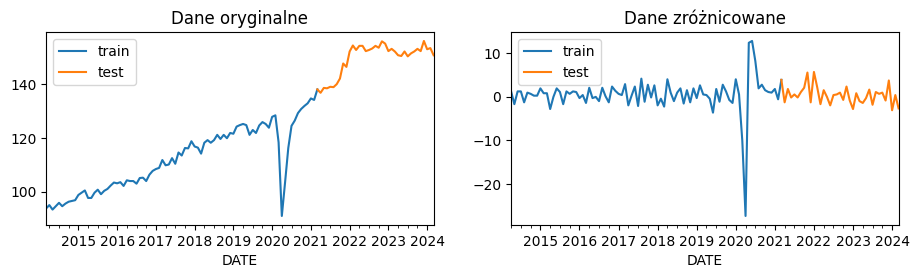

In [95]:
# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(11, 2.5))
axs = axs.ravel()
ts1.loc[:end_train].plot(ax=axs[0], label='train')
ts1.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Dane oryginalne')

ts1_diff.loc[:end_train].plot(ax=axs[1], label='train')
ts1_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Dane zróżnicowane')

## Prognozowanie używając drzew losowych i wzmocnienia gradientowego.


Tworzymy dwa autoregresyjne prognozatory. Jeden za pomocą RandomForestRegressor z biblioteki scikit-learn, a drugi z użyciem XGBoost. Oba zostały wytrenowane na danych od 2014-03-01 do 2024-03-01 i generują prognozy na kolejne 60 miesięcy (5 lat).(???)

Przykła użycia bibliotek z drzewami

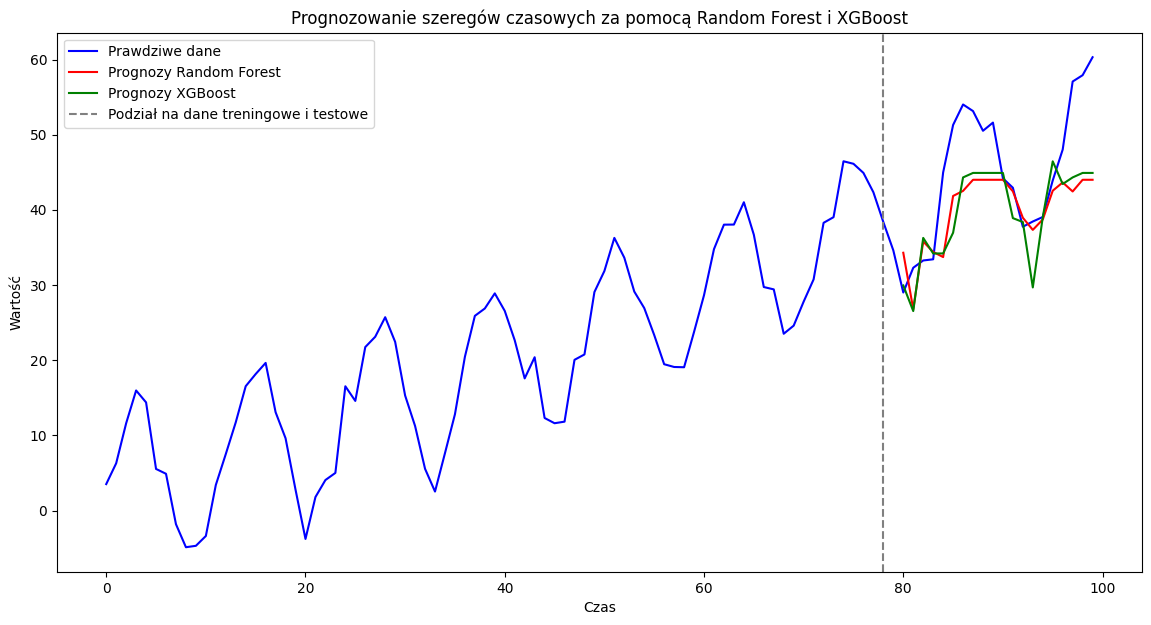

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Generowanie syntetycznego szeregu czasowego
np.random.seed(0)
n = 100
time = np.arange(n)
trend = time * 0.5
seasonal = 10 * np.sin(2 * np.pi * time / 12)
noise = np.random.normal(0, 2, n)
series = trend + seasonal + noise
data = pd.DataFrame({'value': series})

# Przygotowanie danych do modelu
data['lag1'] = data['value'].shift(1)
data['lag2'] = data['value'].shift(2)
data = data.dropna()

# Podział na dane treningowe i testowe
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
X_train, y_train = train_data.drop(columns='value'), train_data['value']
X_test, y_test = test_data.drop(columns='value'), test_data['value']

# Trening modelu Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Trening modelu XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Prognozowanie
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Wizualizacja wyników
plt.figure(figsize=(14, 7))
plt.plot(time, series, label='Prawdziwe dane', color='blue')
plt.plot(test_data.index, rf_predictions, label='Prognozy Random Forest', color='red')
plt.plot(test_data.index, xgb_predictions, label='Prognozy XGBoost', color='green')
plt.axvline(x=len(X_train), color='gray', linestyle='--', label='Podział na dane treningowe i testowe')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.title('Prognozowanie szeregów czasowych za pomocą Random Forest i XGBoost')
plt.legend()
plt.show()


## Prognozowanie beż różnocowania

In [101]:
# Forecasting without differentiation
# ==============================================================================
steps = len(ts1.loc[end_train:])

In [127]:
# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12
                )
forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12
                )

In [128]:
# Train
forecaster_rf.fit(ts1.loc[:end_train])
forecaster_gb.fit(ts1.loc[:end_train])

In [129]:
# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

In [130]:
# Error
error_rf = mean_absolute_error(ts1.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(ts1.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# stosunkowo małe błędy

Error (MAE) Random Forest: 15.56
Error (MAE) Gradient Boosting: 12.78


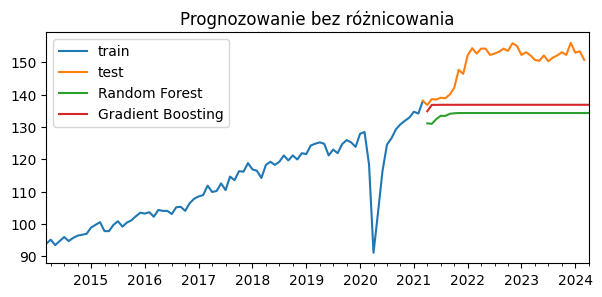

In [131]:
# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
ts1.loc[:end_train].plot(ax=ax, label='train')
ts1.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Prognozowanie bez różnicowania')
ax.set_xlabel('')
ax.legend()

Wykres pokazuje, że żaden z modeli nie jest w stanie dokładnie przewidzieć trendu. Po kilku krokach prognozy stają się niemal stałe, zbliżone do maksymalnych wartości obserwowanych w danych treningowych.

Następnie dwa nowe prognozatory są trenowane przy użyciu tej samej konfiguracji, ale z argumentem differentiation = 1. Aktywuje to wewnętrzny proces różnicowania (rząd 1) szeregu czasowego przed trenowaniem modelu i odwraca różnicowanie (znane również jako całkowanie) dla wartości prognozowanych.

## Prognozowanbe z różnicowaniem

In [134]:
# Forecasting with differentiation
# ==============================================================================
steps = len(ts1.loc[end_train:])


In [135]:
# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor       = RandomForestRegressor(random_state=910),
                    lags            = 12,
                    differentiation = 1 #dodajemy różnicowanie
                )
forecaster_gb = ForecasterAutoreg(
                    regressor       = XGBRegressor(random_state=910),
                    lags            = 12,
                    differentiation = 1 #dodajemy różnicowanie
                )

In [136]:
# Train
forecaster_rf.fit(ts1.loc[:end_train])
forecaster_gb.fit(ts1.loc[:end_train])


In [137]:
# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

In [138]:
# Error
error_rf = mean_absolute_error(ts1.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(ts1.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

Error (MAE) Random Forest: 8.01
Error (MAE) Gradient Boosting: 4.56


Widzimy zdecydowanie mniejsze wartości błędów.

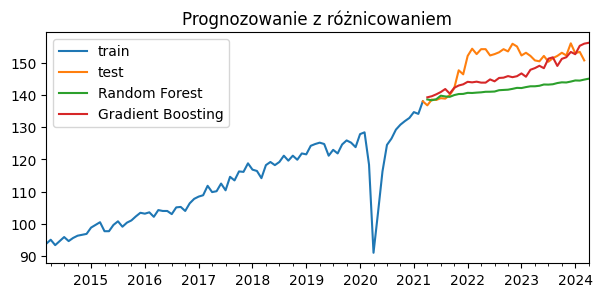

In [139]:
# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
ts1.loc[:end_train].plot(ax=ax, label='train')
ts1.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Prognozowanie z różnicowaniem')
ax.set_xlabel('')
ax.legend()

Można sprawdzić czy jeżli spróbujemy przewidywać sytuacje przed covid-19 to czy prognozy wyglądały inaczej i jaki wpły miała pandemia na zachowanie zjawiska.

## Zagłębienie się w różnicowanie szeregów czasowych








Poprzedni przykład pokazał, jak łatwo jest wprowadzić różnicowanie do procesu prognozowania dzięki funkcjonalnościom dostępnym w skforecast. Jednakże, aby osiągnąć płynną interakcję, konieczne jest zastosowanie kilku nietrywialnych transformacji.

W kolejnych sekcjach przedstawię możliwości transformatora TimeSeriesDifferentiator:

- Różnicowanie i całkowanie (odwracanie różnicowania) dowolnego szereg czasowego.
- Dlaczego zarządzanie różnicowaniem wewnętrznie ma przewagę nad tradycyjnym podejściem polegającym na przekształcaniu całego szeregu czasowego przed rozpoczęciem treningu modelu.
- Jak zarządzać różnicowaniem przy stosowaniu Forecastera do nowych danych, które nie bezpośrednio następują po danych treningowych.

# TimeSeriesDifferentiator


TimeSeriesDifferentiator to niestandardowy transformator, który stosuje się do API przetwarzania wstępnego sklearn. Oznacza to, że posiada metody fit, transform, fit_transform oraz inverse_transform.

In [46]:
# Differentiation with TimeSeriesDifferentiator
# ==============================================================================
y = np.array([5, 8, 12, 10, 14, 17, 21, 19], dtype=float)
diffenciator = TimeSeriesDifferentiator()
diffenciator.fit(y)
y_diff = diffenciator.transform(y)

print(f"Original time series   : {y}")
print(f"Differenced time series: {y_diff}")

Original time series   : [ 5.  8. 12. 10. 14. 17. 21. 19.]
Differenced time series: [nan  3.  4. -2.  4.  3.  4. -2.]



Proces różnicowania można odwrócić (całkowanie) za pomocą metody inverse_transform.

In [47]:
# Inverse transform
# ==============================================================================
diffenciator.inverse_transform(y_diff)

array([ 5.,  8., 12., 10., 14., 17., 21., 19.])

Proces odwrotnej transformacji, inverse_transform, można zastosować tylko do tego samego szeregu czasowego, który wcześniej był różnicowany za pomocą tego samego obiektu TimeSeriesDifferentiator. To ograniczenie wynika z konieczności użycia początkowych n wartości szeregu czasowego (gdzie n równa się rzędowi różnicowania) do pomyślnego odwrócenia różnicowania. Te wartości są przechowywane podczas wykonywania metody fit.

W transformatorze TimeSeriesDifferentiator dostępna jest dodatkowa metoda inverse_transform_next_window. Metoda ta została zaprojektowana do użycia wewnątrz prognozatorów (Forecasters) w celu odwrócenia różnicowania wartości prognozowanych. Jeśli regressor prognozatora jest trenowany na różnicowanym szeregu czasowym, to prognozowane wartości również będą różnicowane. Metoda inverse_transform_next_window pozwala na przywrócenie prognoz do oryginalnej skali, zakładając, że zaczynają się one bezpośrednio po ostatnich obserwowanych wartościach (last_window).

# Różnicowanie wewnętrzne vs przetwarzanie wstępne

Prognozatory zarządzają procesem różnicowania wewnętrznie, więc nie ma potrzeby dodatkowego przetwarzania wstępnego szeregu czasowego ani postprocesowania prognoz. Ma to kilka zalet, ale zanim się w nie zagłębimy, porównane zostaną wyniki obu podejść.

In [146]:
# Time series differentiated by preprocessing before training
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(ts11)
data_diff = pd.Series(data_diff, index=ts1.index).dropna()

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
forecaster.fit(y=data_diff.loc[:end_train])
predictions_diff = forecaster.predict(steps=steps)

# Revert differentiation to obtain final predictions
last_value_train = ts1.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
predictions_1 = predictions_1.asfreq('MS')
predictions_1.name = 'pred'
predictions_1.head(5)

2021-04-01    139.062341
2021-05-01    139.041399
2021-06-01    138.315471
2021-07-01    138.961815
2021-08-01    138.351763
Freq: MS, Name: pred, dtype: float64

In [148]:
# Error
error_1 = mean_absolute_error(ts1.loc[end_train:], predictions_1)
error_1

8.622837859459462

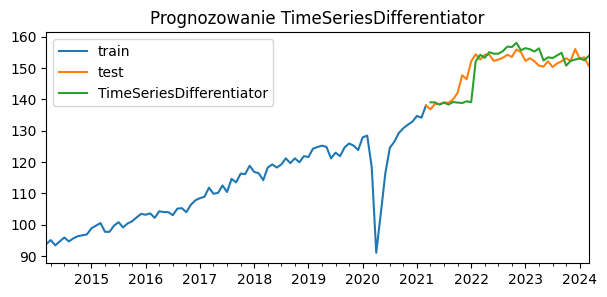

In [144]:
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
ts1.loc[:end_train].plot(ax=ax, label='train')
ts1.loc[end_train:].plot(ax=ax, label='test')
predictions_1['pred'].plot(ax=ax, label='TimeSeriesDifferentiator')

ax.set_title(f'Prognozowanie TimeSeriesDifferentiator')
ax.set_xlabel('')
ax.legend()

In [141]:
predictions_1

,pred_diff,backtesting_fold_id,previous_overved_value,summed_value,pred
2021-04-01,0.998141,0,138.0642,139.062341,139.062341
2021-05-01,-0.020941,0,0.0000,-0.020941,139.041399
2021-06-01,-0.725929,0,0.0000,-0.725929,138.315471
2021-07-01,0.646344,0,0.0000,0.646344,138.961815
2021-08-01,-0.610052,0,0.0000,-0.610052,138.351763
2021-09-01,0.265238,1,138.9018,139.167038,139.167038
2021-10-01,-0.185670,1,0.0000,-0.185670,138.981368
2021-11-01,-0.166127,1,0.0000,-0.166127,138.815241
2021-12-01,0.597481,1,0.0000,0.597481,139.412721
2022-01-01,-0.326665,1,0.0000,-0.326665,139.086056


Dodać opis dlaczego takie wyniki

# Session information

Dodać opis

In [67]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.7.1
numpy               1.24.2
pandas              1.5.3
session_info        1.0.0
skforecast          0.12.1
sklearn             1.4.2
xgboost             2.0.3
-----
IPython             8.11.0
jupyter_client      8.0.3
jupyter_core        5.2.0
jupyterlab          3.6.1
notebook            6.5.3
-----
Python 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2024-06-06 10:51
